**Fixed Effects Model**

In [5]:
%pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 50.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 21.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install pandas matplotlib seaborn statsmodels openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 9.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Dependencies
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


In [40]:
# Load your Excel sheet
df = pd.read_excel("LLM_Risk_Data.xlsx")

# Check basic structure
df.head()
df.info()
print(df.groupby(['Patient_ID', 'Condition']).size())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  180 non-null    object 
 1   Condition   180 non-null    object 
 2   AddedVars   180 non-null    int64  
 3   Trial       180 non-null    int64  
 4   Risk_Score  180 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.2+ KB
Patient_ID  Condition
P00         Baseline     5
            add_1        5
            add_6        5
P01         Baseline     5
            add_1        5
            add_6        5
P02         Baseline     5
            add_1        5
            add_6        5
P03         Baseline     5
            add_1        5
            add_6        5
P04         Baseline     5
            add_1        5
            add_6        5
P05         Baseline     5
            add_1        5
            add_6        5
P06         Baseline     5
            

In [19]:
import statsmodels.formula.api as smf

model = smf.mixedlm("Risk_Score ~ AddedVars", df, groups=df["Patient_ID"])
result = model.fit()
print(result.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Risk_Score
No. Observations: 180     Method:             REML      
No. Groups:       12      Scale:              1.1972    
Min. group size:  15      Log-Likelihood:     -294.8590 
Max. group size:  15      Converged:          Yes       
Mean group size:  15.0                                  
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  6.264     0.513  12.216  0.000   5.259   7.270
AddedVars  0.045     0.031   1.433  0.152  -0.016   0.105
Group Var  3.013     1.244                               



*not absolute, need to adjust

In [43]:
# Calculate mean baseline per patient
baseline_means = df[df["Condition"] == "Baseline"].groupby("Patient_ID")["Risk_Score"].mean().rename("Baseline_Risk")

# Merge baseline back into the main DataFrame
df = df.merge(baseline_means, on="Patient_ID", how="left")

# Compute absolute delta risk
df["Abs_Delta_Risk"] = (df["Risk_Score"] - df["Baseline_Risk"]).abs()
df.head()


,Patient_ID,Condition,AddedVars,Trial,Risk_Score,Baseline_Risk_x,Abs_Delta_Risk,Baseline_Risk_y,Baseline_Risk
0,P00,Baseline,0,1,5.5,5.3,0.2,5.3,5.3
1,P00,Baseline,0,2,5.0,5.3,0.3,5.3,5.3
2,P00,Baseline,0,3,5.5,5.3,0.2,5.3,5.3
3,P00,Baseline,0,4,5.0,5.3,0.3,5.3,5.3
4,P00,Baseline,0,5,5.5,5.3,0.2,5.3,5.3


In [44]:

# Fit the model
model = smf.mixedlm("Abs_Delta_Risk ~ AddedVars", df, groups=df["Patient_ID"])
result = model.fit()
print(result.summary())


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Abs_Delta_Risk
No. Observations: 180     Method:             REML          
No. Groups:       12      Scale:              0.5710        
Min. group size:  15      Log-Likelihood:     -209.5963     
Max. group size:  15      Converged:          No            
Mean group size:  15.0                                      
--------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
--------------------------------------------------------------
Intercept   0.564      0.078   7.195   0.000    0.410    0.717
AddedVars   0.136      0.021   6.338   0.000    0.094    0.178
Group Var   0.006      0.022                                  



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python

In [22]:

summary = df.groupby("Condition").agg(
    Mean_Risk=("Risk_Score", "mean"),
    SE_Risk=("Risk_Score", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

print(summary)


  Condition  Mean_Risk   SE_Risk
0  Baseline   6.181667  0.226388
1     add_1   6.408333  0.260120
2     add_6   6.515000  0.285357


<Figure size 800x600 with 0 Axes>

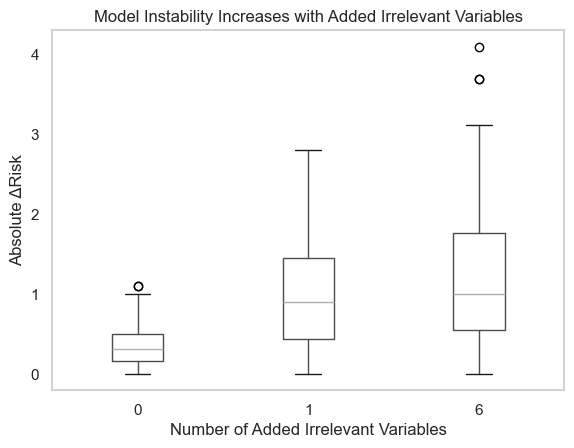

In [46]:
plt.figure(figsize=(8, 6))
df.boxplot(column="Abs_Delta_Risk", by="AddedVars", grid=False)

plt.title("Model Instability Increases with Added Irrelevant Variables")
plt.suptitle("")  # removes automatic subtitle
plt.xlabel("Number of Added Irrelevant Variables")
plt.ylabel("Absolute ΔRisk")
plt.show()


<Figure size 800x600 with 0 Axes>

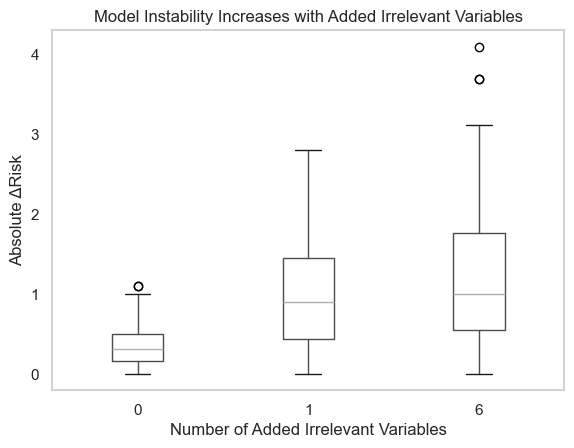

In [47]:
plt.figure(figsize=(8, 6))
df.boxplot(column="Abs_Delta_Risk", by="AddedVars", grid=False)

plt.title("Model Instability Increases with Added Irrelevant Variables")
plt.suptitle("")  # removes automatic subtitle
plt.xlabel("Number of Added Irrelevant Variables")
plt.ylabel("Absolute ΔRisk")
plt.show()


/var/folders/z_/5vjxj12n6l1_lx8vl9hfs5h80000gn/T/ipykernel_27848/628084729.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


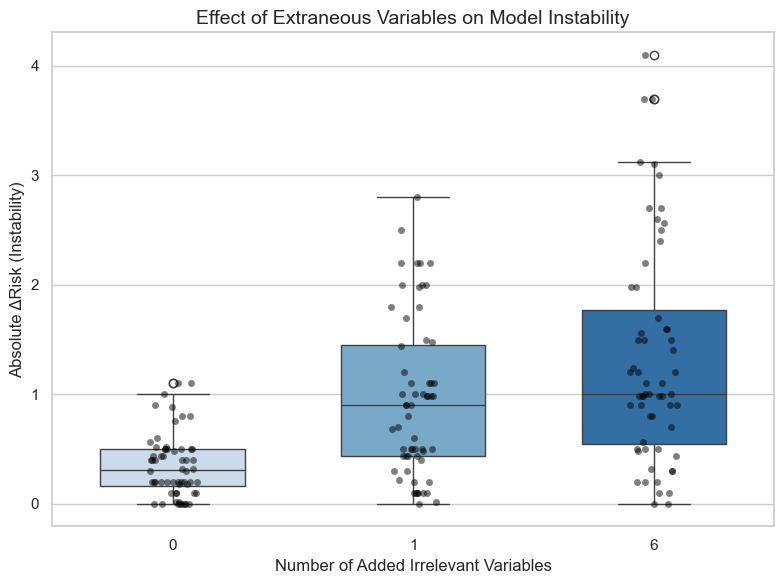

In [50]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="AddedVars",
    y="Abs_Delta_Risk",
    palette="Blues",
    width=0.6
)

sns.stripplot(
    data=df,
    x="AddedVars",
    y="Abs_Delta_Risk",
    color="black",
    alpha=0.5,
    jitter=True
)

plt.title("Effect of Extraneous Variables on Model Instability", fontsize=14)
plt.xlabel("Number of Added Irrelevant Variables", fontsize=12)
plt.ylabel("Absolute ΔRisk (Instability)", fontsize=12)
plt.tight_layout()
plt.show()


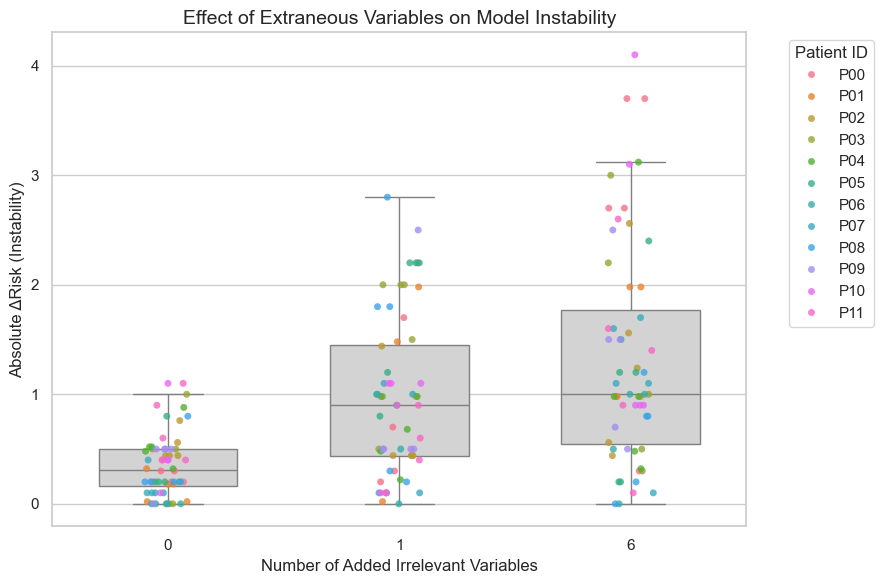

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged' DataFrame includes:
# ['Patient_ID', 'AddedVars', 'Abs_Delta_Risk']

plt.figure(figsize=(9, 6))

# Boxplot for overall distribution
sns.boxplot(
    data=df,
    x="AddedVars",
    y="Abs_Delta_Risk",
    color="lightgray",
    width=0.6,
    showfliers=False
)

# Overlay jittered points, colored by patient
sns.stripplot(
    data=df,
    x="AddedVars",
    y="Abs_Delta_Risk",
    hue="Patient_ID",
    palette="husl",
    dodge=False,
    alpha=0.8,
    jitter=True,
    size=5
)

plt.title("Effect of Extraneous Variables on Model Instability", fontsize=14)
plt.xlabel("Number of Added Irrelevant Variables", fontsize=12)
plt.ylabel("Absolute ΔRisk (Instability)", fontsize=12)
plt.legend(title="Patient ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


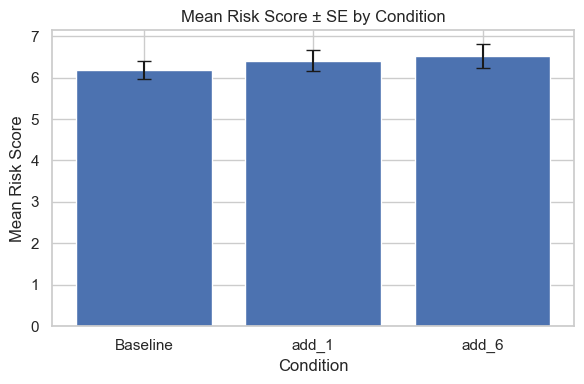

In [23]:
plt.figure(figsize=(6,4))
plt.bar(summary["Condition"], summary["Mean_Risk"], yerr=summary["SE_Risk"], capsize=5)
plt.xlabel("Condition")
plt.ylabel("Mean Risk Score")
plt.title("Mean Risk Score ± SE by Condition")
plt.tight_layout()
plt.show()


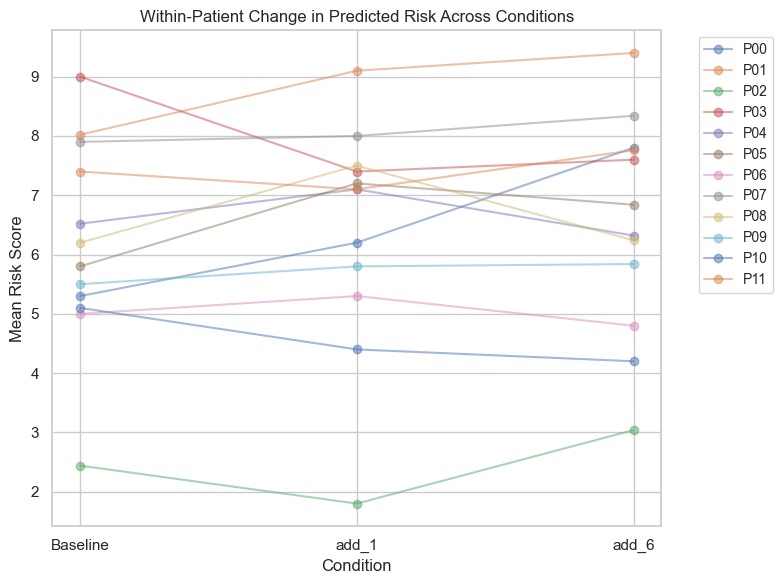

In [25]:

# Compute per-patient means for each condition
summary = df.groupby(["Patient_ID", "Condition"]).agg(
    Mean_Risk=("Risk_Score", "mean")
).reset_index()

plt.figure(figsize=(8,6))
for pid, pdata in summary.groupby("Patient_ID"):
    plt.plot(pdata["Condition"], pdata["Mean_Risk"], marker='o', label=pid, alpha=0.5)

plt.xlabel("Condition")
plt.ylabel("Mean Risk Score")
plt.title("Within-Patient Change in Predicted Risk Across Conditions")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


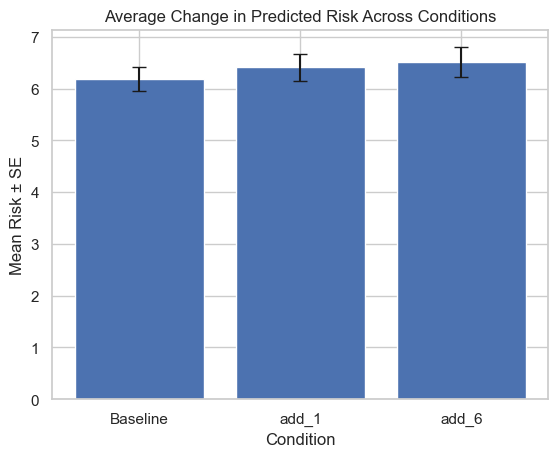

In [26]:
import numpy as np

summary2 = df.groupby("Condition").agg(
    Mean_Risk=("Risk_Score", "mean"),
    SE_Risk=("Risk_Score", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

plt.bar(summary2["Condition"], summary2["Mean_Risk"], yerr=summary2["SE_Risk"], capsize=5)
plt.title("Average Change in Predicted Risk Across Conditions")
plt.ylabel("Mean Risk ± SE")
plt.xlabel("Condition")
plt.show()


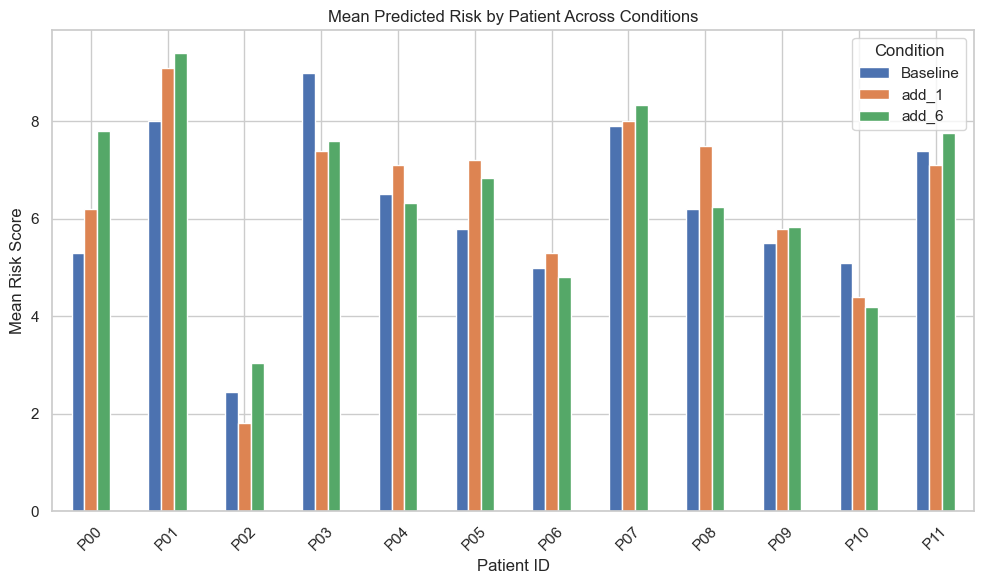

In [28]:


# Compute per-patient mean risk per condition
summary = df.groupby(["Patient_ID", "Condition"])["Risk_Score"].mean().reset_index()

# Pivot for grouped bar format
pivot_df = summary.pivot(index="Patient_ID", columns="Condition", values="Risk_Score")

# Plot grouped bar chart
pivot_df.plot(kind="bar", figsize=(10,6))

plt.title("Mean Predicted Risk by Patient Across Conditions")
plt.xlabel("Patient ID")
plt.ylabel("Mean Risk Score")
plt.xticks(rotation=45)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()


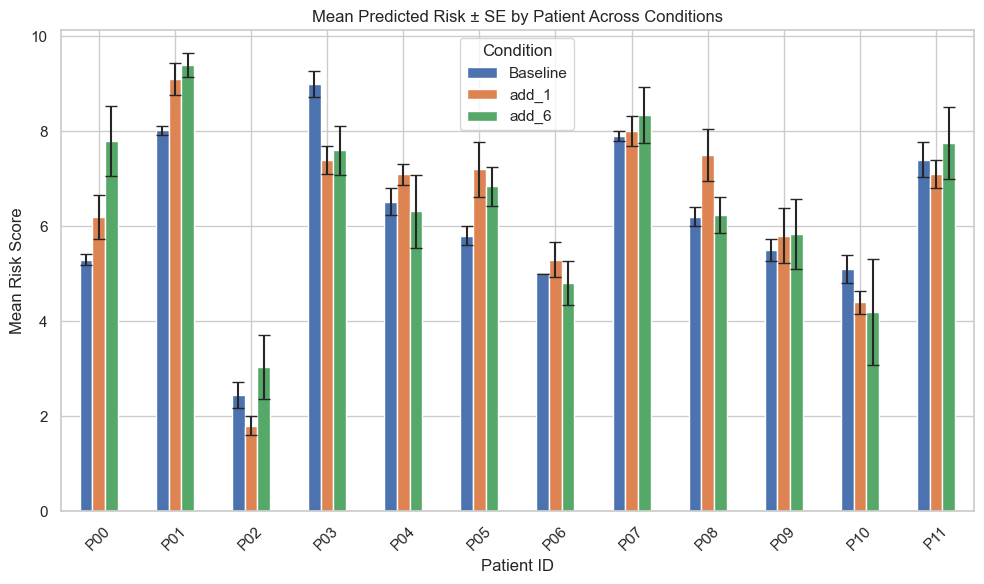

In [29]:
stats = df.groupby(["Patient_ID", "Condition"])["Risk_Score"].agg(
    Mean="mean",
    SE=lambda x: x.std(ddof=1) / (len(x)**0.5)
).reset_index()

mean_pivot = stats.pivot(index="Patient_ID", columns="Condition", values="Mean")
se_pivot = stats.pivot(index="Patient_ID", columns="Condition", values="SE")

ax = mean_pivot.plot(kind="bar", yerr=se_pivot, capsize=4, figsize=(10,6))
plt.title("Mean Predicted Risk ± SE by Patient Across Conditions")
plt.xlabel("Patient ID")
plt.ylabel("Mean Risk Score")
plt.xticks(rotation=45)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()


One Tailed T-Test

In [36]:
import pandas as pd
from scipy import stats

# Load your file
df1 = pd.read_excel("Exp1_AnalysisData.xlsx") 

# Check the first few rows
df1.head()


,Patient ID,Avg_Baseline_RiskScore,Avg_add6_RiskScore,Avg_add1_RiskScore,Mean_Delta_Risk-add6,Mean_Delta_Risk-add1,sd_Baseline,sd_add_6,sd_add_1,Var_Baseline,Var_add_6,Var_add_1,Variance_Ratio = (sd_add_6^2) / (sd_Baseline^2)
0,P00,5.30,7.80,6.2,2.50,0.90,0.273861,1.643168,1.036822,0.075,2.700,1.075,36.000000
1,P01,8.02,9.40,9.1,1.38,1.08,0.204939,0.547723,0.741620,0.042,0.300,0.550,7.142857
2,P02,2.44,3.04,1.8,0.60,0.64,0.606630,1.519210,0.447214,0.368,2.308,0.200,6.271739
3,P03,9.00,7.60,7.4,1.40,1.60,0.612372,1.159741,0.651920,0.375,1.345,0.425,3.586667
4,P04,6.52,6.32,7.1,0.20,0.58,0.641872,1.716683,0.494975,0.412,2.947,0.245,7.152913


In [37]:
# One-tailed t-test for add6
t_add6, p_two_add6 = stats.ttest_1samp(df1["Mean_Delta_Risk-add6"], 0)
p_one_add6 = p_two_add6 / 2 if t_add6 > 0 else 1 - (p_two_add6 / 2)

# One-tailed t-test for add1
t_add1, p_two_add1 = stats.ttest_1samp(df1["Mean_Delta_Risk-add1"], 0)
p_one_add1 = p_two_add1 / 2 if t_add1 > 0 else 1 - (p_two_add1 / 2)

print(f"Add 6 Vars — t = {t_add6:.3f}, one-tailed p = {p_one_add6:.5f}")
print(f"Add 1 Var — t = {t_add1:.3f}, one-tailed p = {p_one_add1:.5f}")

alpha = 0.05
if p_one_add6 < alpha:
    print("adding 6 irrelevant variables increases risk score magnitude.")
else:
    print("Not significant for add6 condition.")

if p_one_add1 < alpha:
    print("adding 1 irrelevant variable increases risk score magnitude.")
else:
    print("Not significant for add1 condition.")


Add 6 Vars — t = 3.830, one-tailed p = 0.00140
Add 1 Var — t = 5.412, one-tailed p = 0.00011
adding 6 irrelevant variables increases risk score magnitude.
adding 1 irrelevant variable increases risk score magnitude.


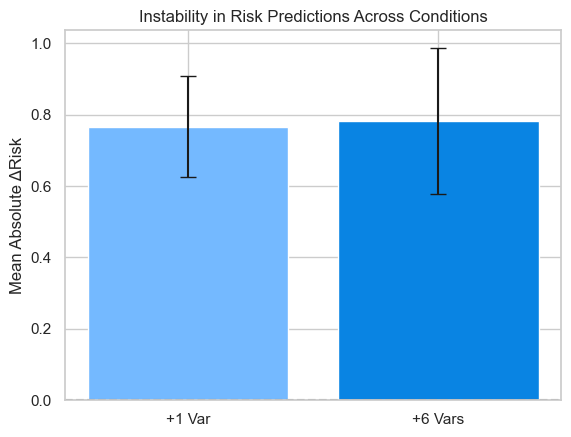

In [38]:

means = [
    df1["Mean_Delta_Risk-add1"].mean(),
    df1["Mean_Delta_Risk-add6"].mean()
]
sems = [
    stats.sem(df1["Mean_Delta_Risk-add1"]),
    stats.sem(df1["Mean_Delta_Risk-add6"])
]

conditions = ["+1 Var", "+6 Vars"]

plt.bar(conditions, means, yerr=sems, capsize=6, color=["#74b9ff", "#0984e3"])
plt.axhline(0, color="gray", linestyle="--")
plt.ylabel("Mean Absolute ΔRisk")
plt.title("Instability in Risk Predictions Across Conditions")
plt.show()
